In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_consistent_length

from catboost import CatBoostClassifier

In [2]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

In [3]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [4]:
df = pd.read_csv('HW_data.csv')
df.head(5)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

In [5]:
df = df.rename({"offer": "treatment", "conversion": "target"}, axis = 'columns')
df.head(5)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

         treatment  target  
0  Buy One Get One       0  
1         No Offer       0  
2  Buy One Get One       0  
3         Discount       0  
4  Buy One Get One       0

In [6]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [7]:
# df['treatment'] = df['treatment'].map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  object 
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [9]:
for cat_colname in df[df.columns[1:]].select_dtypes(include = 'object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

zip_code

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
****************************************************************************************************

channel

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
****************************************************************************************************

treatment

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64
****************************************************************************************************



In [10]:
df.groupby("treatment")['target'].describe()

count      mean       std  min  25%  50%  75%  max
treatment                                                            
Buy One Get One  21387.0  0.151400  0.358447  0.0  0.0  0.0  0.0  1.0
Discount         21307.0  0.182757  0.386476  0.0  0.0  0.0  0.0  1.0
No Offer         21306.0  0.106167  0.308059  0.0  0.0  0.0  0.0  1.0

In [12]:
df = pd.concat([pd.get_dummies(df.treatment, prefix='treatment'), df], axis = 1)
df['treatment'] = df['treatment'].map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})
df.head(3)

treatment_Buy One Get One  treatment_Discount  treatment_No Offer  recency  \
0                          1                   0                   0       10   
1                          0                   0                   1        6   
2                          1                   0                   0        7   

   history  used_discount  used_bogo   zip_code  is_referral channel  \
0   142.44              1          0  Surburban            0   Phone   
1   329.08              1          1      Rural            1     Web   
2   180.65              0          1  Surburban            1     Web   

   treatment  target  
0          1       0  
1          0       0  
2          1       0

(array([4.16228128e-03, 1.82343657e-03, 1.10686939e-03, 6.75289284e-04,
        4.42465033e-04, 2.87248865e-04, 1.82357793e-04, 1.20016873e-04,
        7.61944577e-05, 4.99010085e-05, 3.76024596e-05, 2.68588997e-05,
        1.83771419e-05, 1.11676478e-05, 9.61265885e-06, 4.52360417e-06,
        4.38224154e-06, 2.82725260e-06, 2.12043945e-06, 9.89538411e-07,
        2.82725260e-07, 4.24087891e-07, 0.00000000e+00, 2.82725260e-07,
        5.65450521e-07, 5.65450521e-07, 1.41362630e-07, 1.41362630e-07,
        1.41362630e-07, 1.41362630e-07]),
 array([  29.99      ,  140.52133333,  251.05266667,  361.584     ,
         472.11533333,  582.64666667,  693.178     ,  803.70933333,
         914.24066667, 1024.772     , 1135.30333333, 1245.83466667,
        1356.366     , 1466.89733333, 1577.42866667, 1687.96      ,
        1798.49133333, 1909.02266667, 2019.554     , 2130.08533333,
        2240.61666667, 2351.148     , 2461.67933333, 2572.21066667,
        2682.742     , 2793.27333333, 2903.804

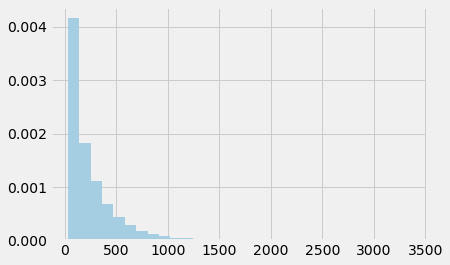

In [13]:
plt.hist(df['history'], density=True, bins=30)

In [14]:
[np.quantile(df['history'], q) for q in [0.25, 0.50, 0.75]]

[64.66, 158.11, 325.65749999999997]

In [15]:
df.loc[df['history'] <= np.quantile(df['history'], 0.25), 'history_range'] = 1
df.loc[(df['history'] > np.quantile(df['history'], 0.25)) & (df['history'] <= np.quantile(df['history'], 0.50)), 'history_range'] = 2
df.loc[(df['history'] > np.quantile(df['history'], 0.50)) & (df['history'] <= np.quantile(df['history'], 0.75)), 'history_range'] = 3
df.loc[df['history'] > np.quantile(df['history'], 0.75), 'history_range'] = 4

In [16]:
df.head()

treatment_Buy One Get One  treatment_Discount  treatment_No Offer  recency  \
0                          1                   0                   0       10   
1                          0                   0                   1        6   
2                          1                   0                   0        7   
3                          0                   1                   0        9   
4                          1                   0                   0        2   

   history  used_discount  used_bogo   zip_code  is_referral channel  \
0   142.44              1          0  Surburban            0   Phone   
1   329.08              1          1      Rural            1     Web   
2   180.65              0          1  Surburban            1     Web   
3   675.83              1          0      Rural            1     Web   
4    45.34              1          0      Urban            0     Web   

   treatment  target  history_range  
0          1       0            2.0  
1          0       0            4.0  
2          1       0            3.0  
3          1       0            4.0  
4          1       0            1.0

In [17]:
cat_features = [col for col in df.select_dtypes(include='object').columns]
# NUM_FEATURE_NAMES = ['recency', 'history']
cat_features

['zip_code', 'channel']

In [18]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# df_norm = df.copy()
# df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
# df_norm.head(3)

In [19]:
indices_train = df.index
indices_learn, indices_valid = train_test_split(df.index, test_size = 0.3, random_state = 123)

In [20]:
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']
X_train = df.drop(['target', 'treatment'], axis = 1).loc[indices_learn, :]

y_val = df.loc[indices_valid, 'target']
treat_val = df.loc[indices_valid, 'treatment']
X_val = df.drop(['target', 'treatment'], axis = 1).loc[indices_valid, :]

y_train_full = df.loc[indices_train, 'target']
treat_train_full = df.loc[indices_train, 'treatment']
X_train_full = df.drop(['target', 'treatment'], axis = 1).loc[indices_train, :]

In [21]:
X_train.shape, y_train.shape, treat_train.shape

((44800, 11), (44800,), (44800,))

In [22]:
X_val.shape, y_val.shape, treat_val.shape

((19200, 11), (19200,), (19200,))

In [23]:
X_train_full.shape, y_train_full.shape, treat_train_full.shape

((64000, 11), (64000,), (64000,))

In [24]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

In [25]:
def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

#### single model

In [26]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

In [27]:
sm.trmnt_preds_

array([0.19384786, 0.22289179, 0.04874048, ..., 0.22309167, 0.25674612,
       0.16051009])

In [28]:
sm.ctrl_preds_

array([0.19516952, 0.20154306, 0.0410981 , ..., 0.20301169, 0.21094765,
       0.15847801])

In [29]:
sm_score

0.06188057776708382

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

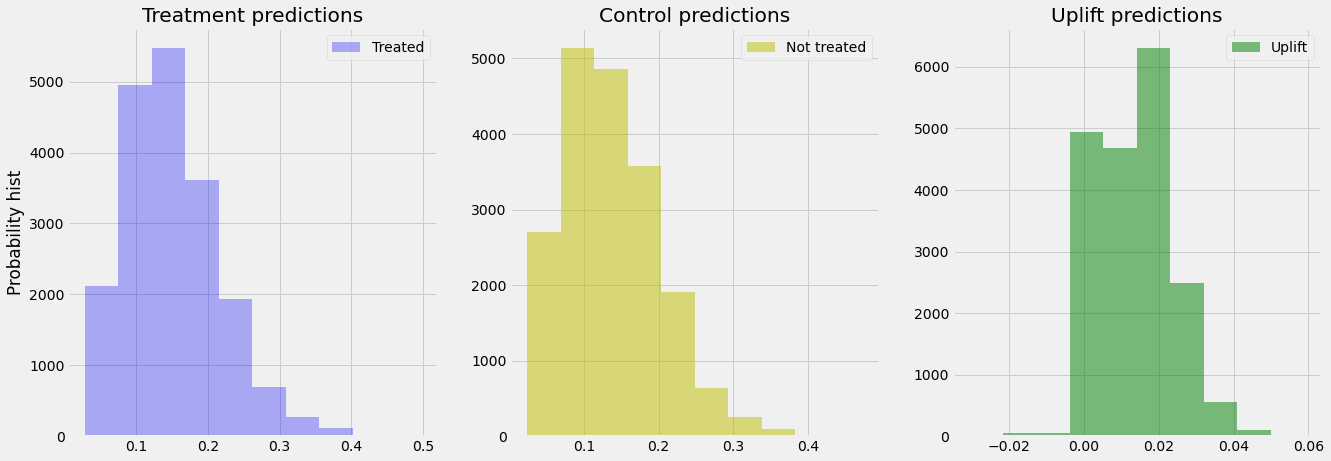

In [30]:
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds_(   sm_trmnt_preds , sm_ctrl_preds, bins=10)

In [31]:
# топ-признаки
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

feature_name  feature_score
0                 is_referral      16.645672
1                   used_bogo      12.394016
2                     recency      10.787013
3                    zip_code       8.836549
4               used_discount       8.674978
5          treatment_No Offer       7.748325
6                     history       7.271613
7          treatment_Discount       7.174531
8               history_range       7.143750
9                     channel       6.467330
10                  treatment       4.080459
11  treatment_Buy One Get One       2.775763

#### conv vs uplift score

In [32]:
res_sm = pd.DataFrame(uplift_sm, columns = ['uplift_score'], index = y_val.index)


In [33]:
uplift_conv = pd.concat([res_sm, y_val], axis = 1).sort_values(by = ['uplift_score'], ascending = False)
uplift_conv.head(3)

uplift_score  target
32674      0.058897       1
44151      0.058863       1
11430      0.056613       0

In [34]:
uplift_conv['range'] = pd.qcut(uplift_conv['uplift_score'], 10)

In [35]:
uplift_conv.head()

uplift_score  target             range
32674      0.058897       1  (0.0272, 0.0589]
44151      0.058863       1  (0.0272, 0.0589]
11430      0.056613       0  (0.0272, 0.0589]
5464       0.054766       0  (0.0272, 0.0589]
62545      0.054766       0  (0.0272, 0.0589]

In [36]:
d = {}
for r in uplift_conv['range'].astype(str).unique():
    d[r] =  uplift_conv.loc[uplift_conv['range'].astype(str) == r, 'target'].mean()
d

{'(0.0272, 0.0589]': 0.17395833333333333,
 '(0.0213, 0.0272]': 0.16866840731070495,
 '(0.0184, 0.0213]': 0.17246753246753246,
 '(0.0162, 0.0184]': 0.17239583333333333,
 '(0.014, 0.0162]': 0.14853556485355648,
 '(0.0109, 0.014]': 0.11752470098803952,
 '(0.00735, 0.0109]': 0.08207792207792208,
 '(0.00205, 0.00735]': 0.13177083333333334,
 '(0.00108, 0.00205]': 0.14900314795383002,
 '(-0.031599999999999996, 0.00108]': 0.15305067218200621}

Выглядит как отсутствие зависимости между uplift скором и таргетом

#### class transformation

In [37]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


In [38]:
ct_score

0.18218307350886326

#### two models

In [39]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

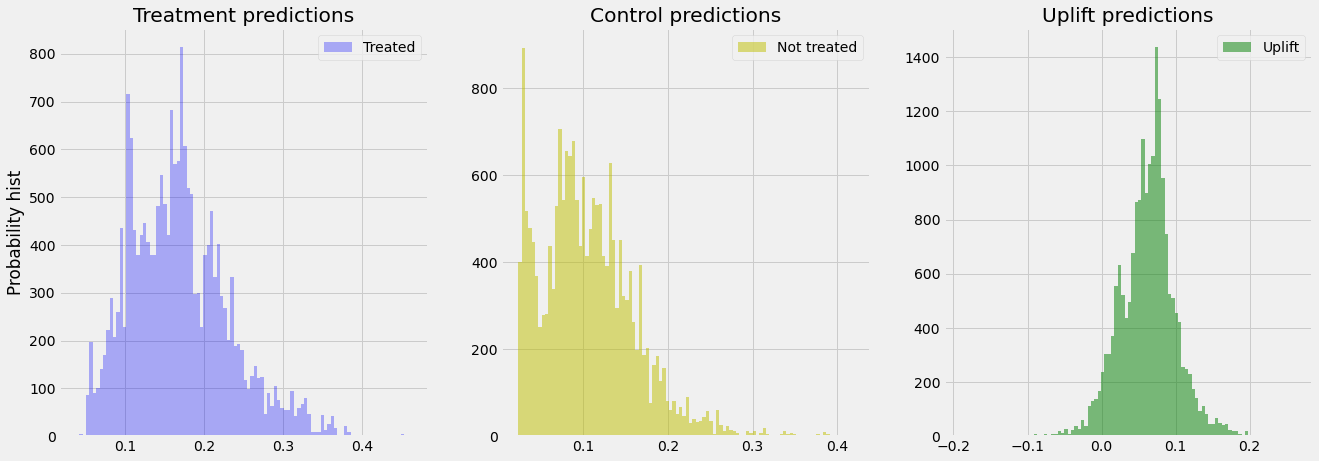

In [40]:
plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [41]:
tm_score

0.08141929291973007

In [42]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

approach  uplift@30%
1  ClassTransformation    0.182183
2            TwoModels    0.081419
0            SoloModel    0.061881

#### uplift tree

In [43]:
dummies_train = pd.concat([pd.get_dummies(X_train['zip_code'], prefix='zip_code'), pd.get_dummies(X_train['channel'], prefix='channel')], axis = 1)
dummies_val = pd.concat([pd.get_dummies(X_val['zip_code'], prefix='zip_code'), pd.get_dummies(X_val['channel'], prefix='channel')], axis = 1)
dummies_train

zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
53181               0                   1               0   
42635               0                   0               1   
6296                1                   0               0   
41722               1                   0               0   
32660               0                   0               1   
...               ...                 ...             ...   
61404               0                   1               0   
17730               0                   1               0   
28030               1                   0               0   
15725               0                   1               0   
52734               1                   0               0   

       channel_Multichannel  channel_Phone  channel_Web  
53181                     0              0            1  
42635                     0              1            0  
6296                      0              0            1  
41722                     0              0            1  
32660                     0              0            1  
...                     ...            ...          ...  
61404                     0              0            1  
17730                     0              1            0  
28030                     1              0            0  
15725                     0              1            0  
52734                     0              0            1  

[44800 rows x 6 columns]

In [44]:
X_train_tree = pd.concat([X_train.drop(['zip_code', 'channel'], axis = 1), dummies_train], axis = 1)
X_val_tree = pd.concat([X_val.drop(['zip_code', 'channel'], axis = 1), dummies_val], axis = 1)
X_train_tree

treatment_Buy One Get One  treatment_Discount  treatment_No Offer  \
53181                          0                   0                   1   
42635                          0                   1                   0   
6296                           0                   0                   1   
41722                          1                   0                   0   
32660                          1                   0                   0   
...                          ...                 ...                 ...   
61404                          0                   1                   0   
17730                          0                   1                   0   
28030                          0                   0                   1   
15725                          1                   0                   0   
52734                          1                   0                   0   

       recency  history  used_discount  used_bogo  is_referral  history_range  \
53181        8   121.56              0          1            0            2.0   
42635        9   617.62              0          1            1            4.0   
6296         5   185.62              1          0            1            3.0   
41722        1   359.03              0          1            0            4.0   
32660       10   139.68              1          0            0            2.0   
...        ...      ...            ...        ...          ...            ...   
61404        1   172.98              1          0            0            3.0   
17730        9    95.41              0          1            0            2.0   
28030        1   547.69              1          1            1            4.0   
15725        5   341.39              0          1            0            4.0   
52734        1    67.15              0          1            0            2.0   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
53181               0                   1               0   
42635               0                   0               1   
6296                1                   0               0   
41722               1                   0               0   
32660               0                   0               1   
...               ...                 ...             ...   
61404               0                   1               0   
17730               0                   1               0   
28030               1                   0               0   
15725               0                   1               0   
52734               1                   0               0   

       channel_Multichannel  channel_Phone  channel_Web  
53181                     0              0            1  
42635                     0              1            0  
6296                      0              0            1  
41722                     0              0            1  
32660                     0              0            1  
...                     ...            ...          ...  
61404                     0              0            1  
17730                     0              1            0  
28030                     1              0            0  
15725                     0              1            0  
52734                     0              0            1  

[44800 rows x 15 columns]

In [45]:
features = [col for col in X_train_tree]

In [46]:
%%time
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)



Wall time: 5.21 s


In [47]:
# uplift_tree_string(uplift_model.fitted_uplift_tree, features)

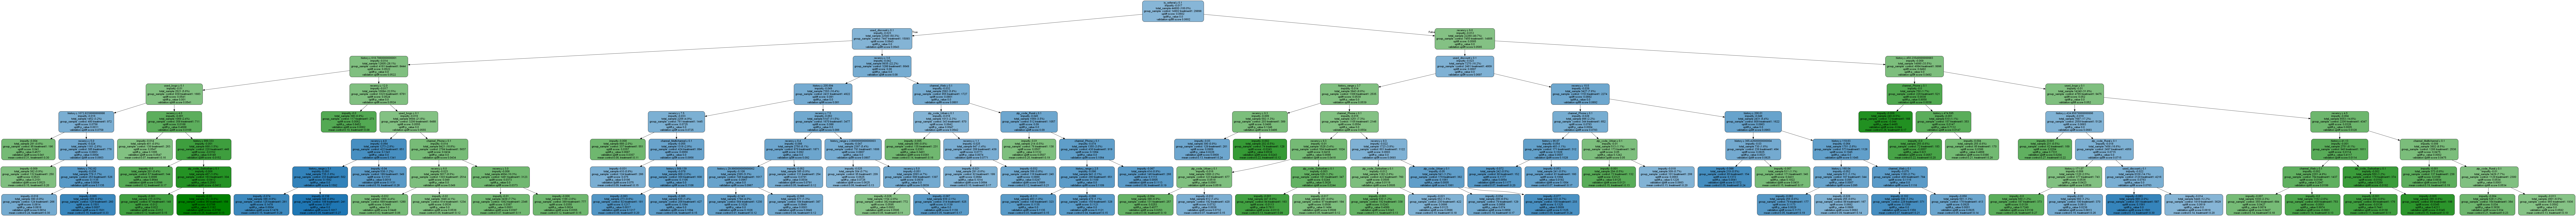

In [48]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

#### uplift forest

In [49]:
%%time
uplift_model_f = UpliftRandomForestClassifier(n_estimators = 100, max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model_f.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)



Wall time: 1min 4s


In [50]:
uplift_rf = uplift_model_f.predict(X_val_tree.values)
rf_score = uplift_at_k(y_true=y_val, uplift=uplift_rf, treatment=treat_val, strategy='by_group', k=0.3)
rf_score

Mean of empty slice.
invalid value encountered in double_scalars


nan

In [51]:
# print(dir(uplift_model_f))

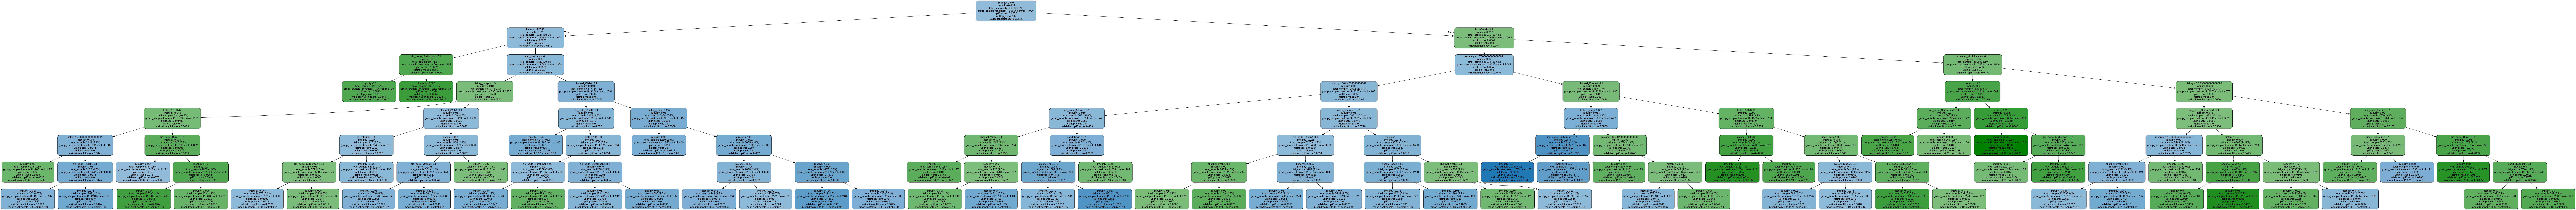

In [52]:
uplift_tree = uplift_model_f.uplift_forest[0]

graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, features)
Image(graph.create_png())

#### observed treatment effect

In [53]:
res_rf = pd.DataFrame(uplift_rf, columns = uplift_model_f.classes_)

In [54]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((res_rf < 0).all(axis=1),
                           'control',
                           res_rf.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(treat_val.map({1: 'treatment1', 0: 'control'}) == best_treatment, 1, 0)
actual_is_control = np.where(treat_val.map({1: 'treatment1', 0: 'control'}) == 'control', 1, 0)

In [55]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = res_rf[synthetic]

In [56]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             conversion = y_val.loc[synthetic].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model_f.classes_)))

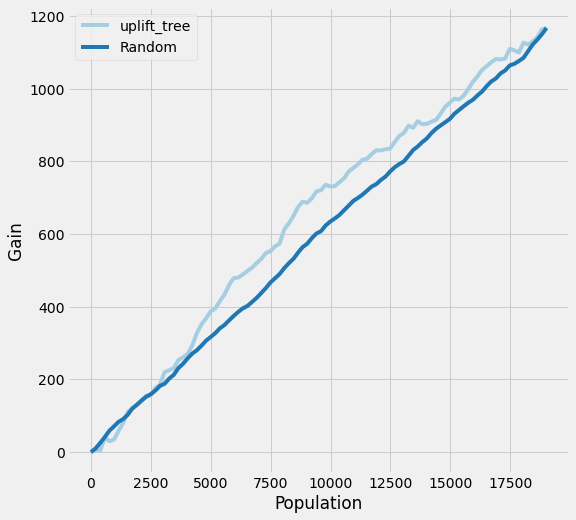

In [57]:
from causalml.metrics import plot_gain
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
